In [82]:
import os
import math
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

# Kaggle input paths
DATA_ROOT = "/kaggle/input/smart-meters-in-london"
METER_PATH = os.path.join(DATA_ROOT, "daily_dataset.csv")
HH_PATH    = os.path.join(DATA_ROOT, "informations_households.csv")
WEA_PATH   = os.path.join(DATA_ROOT, "weather_hourly_darksky.csv")

print("DATA_ROOT =", DATA_ROOT)
print("METER_CSV =", os.path.exists(METER_PATH), METER_PATH)
print("HOUSEHOLD_INFO_CSV =", os.path.exists(HH_PATH), HH_PATH)
print("WEATHER_CSV =", os.path.exists(WEA_PATH), WEA_PATH)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on:", DEVICE)


DATA_ROOT = /kaggle/input/smart-meters-in-london
METER_CSV = True /kaggle/input/smart-meters-in-london/daily_dataset.csv
HOUSEHOLD_INFO_CSV = True /kaggle/input/smart-meters-in-london/informations_households.csv
WEATHER_CSV = True /kaggle/input/smart-meters-in-london/weather_hourly_darksky.csv
Running on: cuda


In [83]:
# Load meter data
dtype_map = {"LCLid": str}
meter_df = pd.read_csv(METER_PATH, dtype=dtype_map)
if "energy_median" in meter_df.columns:
    meter_df["consumption_kwh"] = meter_df["energy_median"].astype(float)
elif "energy_sum" in meter_df.columns:
    meter_df["consumption_kwh"] = meter_df["energy_sum"].astype(float)
else:
    last_num = meter_df.select_dtypes(include=[np.number]).columns[-1]
    meter_df["consumption_kwh"] = meter_df[last_num].astype(float)

meter_df["timestamp"] = pd.to_datetime(meter_df["day"], utc=True)
meter_df.rename(columns={"LCLid": "household_id"}, inplace=True)
meter_df = meter_df[["timestamp", "household_id", "consumption_kwh"]].sort_values(["household_id", "timestamp"])

# Load household data
hh_info = pd.read_csv(HH_PATH)
hh_info.rename(columns={"LCLid": "household_id"}, inplace=True)

# Load weather data
weather = pd.read_csv(WEA_PATH)
time_col = "time" if "time" in weather.columns else weather.columns[0]
weather["timestamp"] = pd.to_datetime(weather[time_col], utc=True)

# Update column names based on actual data
col_map = {}
for c in weather.columns:
    lc = c.lower()
    if "temp" in lc:
        col_map[c] = "temperature"
    elif "humid" in lc:
        col_map[c] = "humidity"
    elif "windspeed" in lc:  # Fixed column name
        col_map[c] = "wind_speed"  # Ensure consistency with the column name

# Rename columns
weather.rename(columns=col_map, inplace=True)

# Now, check that the columns are properly renamed
print(weather.columns)

# Select only necessary columns
weather = weather[["timestamp", "temperature", "humidity", "wind_speed"]]
weather = weather.set_index("timestamp").sort_index()

# Resample weather data to daily mean and forward fill missing data
weather_d = weather.resample("D").mean().ffill().reset_index()

# Merge weather data with meter data based on timestamp
meter_df["timestamp"] = pd.to_datetime(meter_df["timestamp"], utc=True)
combined_data = pd.merge(meter_df, weather_d, on="timestamp", how="left")

# Filter for household MAC000155
combined_data_mac = combined_data[combined_data["household_id"] == "MAC000155"]

# Show the filtered data for MAC000155
print(combined_data_mac.head())


Index(['visibility', 'windBearing', 'temperature', 'time', 'dewPoint',
       'pressure', 'temperature', 'wind_speed', 'precipType', 'icon',
       'humidity', 'summary', 'timestamp'],
      dtype='object')
                       timestamp household_id  consumption_kwh  temperature  \
115961 2011-11-23 00:00:00+00:00    MAC000155           0.3020     7.442083   
115962 2011-11-24 00:00:00+00:00    MAC000155           0.2220    10.377083   
115963 2011-11-25 00:00:00+00:00    MAC000155           0.2325    10.851667   
115964 2011-11-26 00:00:00+00:00    MAC000155           0.2430    10.227083   
115965 2011-11-27 00:00:00+00:00    MAC000155           0.3095    10.832083   

        temperature  humidity  wind_speed  
115961     6.310417  0.925833    2.281250  
115962     9.589583  0.888333    4.069583  
115963    10.168333  0.790417    5.413333  
115964     9.200000  0.807083    5.770417  
115965    10.350833  0.717083    6.080000  


In [84]:
# Thiết lập hiển thị để Pandas không cắt bớt cột
pd.set_option('display.max_columns', None)

# Hiển thị tất cả cột của dữ liệu đã lọc cho hộ gia đình MAC000155
print(combined_data_mac.head())


                       timestamp household_id  consumption_kwh  temperature  \
115961 2011-11-23 00:00:00+00:00    MAC000155           0.3020     7.442083   
115962 2011-11-24 00:00:00+00:00    MAC000155           0.2220    10.377083   
115963 2011-11-25 00:00:00+00:00    MAC000155           0.2325    10.851667   
115964 2011-11-26 00:00:00+00:00    MAC000155           0.2430    10.227083   
115965 2011-11-27 00:00:00+00:00    MAC000155           0.3095    10.832083   

        temperature  humidity  wind_speed  
115961     6.310417  0.925833    2.281250  
115962     9.589583  0.888333    4.069583  
115963    10.168333  0.790417    5.413333  
115964     9.200000  0.807083    5.770417  
115965    10.350833  0.717083    6.080000  


In [85]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size, num_layers=3, dropout=0.3):
        """
        Khởi tạo mô hình LSTM.
        
        Parameters:
        - input_size: số lượng đặc trưng đầu vào (features)
        - hidden_layer_size: kích thước lớp ẩn
        - output_size: kích thước đầu ra (1 giá trị dự đoán)
        - num_layers: số lớp LSTM
        - dropout: tỷ lệ dropout để giảm overfitting
        """
        super(LSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, x):
        """
        Thực hiện quá trình truyền dữ liệu qua mô hình LSTM.
        
        Parameters:
        x: dữ liệu đầu vào (batch_size, seq_length, input_size)
        
        Returns:
        predictions: Dự đoán đầu ra (batch_size, output_size)
        """
        out, _ = self.lstm(x)
        last = out[:, -1, :]  # Lấy đầu ra từ bước cuối cùng của chuỗi
        return self.linear(last)

# Khởi tạo lại mô hình LSTM với số lớp và dropout
hidden_layer_size = 128  # Tăng số unit trong lớp ẩn
num_layers = 3  # Sử dụng 3 lớp LSTM
dropout = 0.3  # Thêm dropout để tránh overfitting

model = LSTMModel(input_size=4, hidden_layer_size=hidden_layer_size, output_size=1, num_layers=num_layers, dropout=dropout).to(DEVICE)

# In ra mô hình đã tạo
print(model)


LSTMModel(
  (lstm): LSTM(4, 128, num_layers=3, batch_first=True, dropout=0.3)
  (linear): Linear(in_features=128, out_features=1, bias=True)
)


In [86]:
# Dataset class for Energy Consumption Time Series
class EnergyDataset(Dataset):
    def __init__(self, data, seq_length=10):
        """
        Khởi tạo dataset cho bài toán chuỗi thời gian.
        
        Parameters:
        data: Dữ liệu chuỗi thời gian
        seq_length: Số lượng bước thời gian cần để tạo mỗi mẫu (sequence length)
        """
        self.data = data
        self.seq_length = seq_length

    def __len__(self):
        """ 
        Trả về số lượng mẫu trong dataset.
        """
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        """
        Lấy mẫu từ dataset với chỉ số idx.
        
        Parameters:
        idx: Chỉ số mẫu cần lấy
        
        Returns:
        x: Đặc trưng đầu vào của mẫu (features)
        y: Giá trị mục tiêu (target)
        """
        x = self.data[idx:idx+self.seq_length, :-1]  # Lấy seq_length bước thời gian từ dữ liệu đầu vào
        y = self.data[idx+self.seq_length, -1]  # Lấy giá trị mục tiêu (tiêu thụ điện) tại bước tiếp theo
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Điều chỉnh kích thước dataset bằng cách chọn số lượng mẫu tùy ý
# Thay đổi tỷ lệ dưới đây để điều chỉnh số lượng mẫu (ví dụ: 10%, 20%, 50%, hoặc toàn bộ dữ liệu)
subset_percentage = 0.05  # Thay đổi giá trị này để tăng/giảm số lượng mẫu
subset_data = combined_data[["consumption_kwh", "temperature", "humidity", "wind_speed"]].values[:int(subset_percentage * len(combined_data))]  # Chọn phần nhỏ của dữ liệu

# Tạo dataset với seq_length là 10
dataset = EnergyDataset(subset_data, seq_length=10)  

# Dataloader với batch_size là 16
train_loader = DataLoader(dataset, batch_size=16, shuffle=True)

# In ra số lượng mẫu trong dataset
print(f"Total number of samples in dataset: {len(dataset)}")


Total number of samples in dataset: 175511


In [87]:
import copy  # Thêm dòng này vào đầu code

# Training the model with Learning Rate Scheduling and Early Stopping
def train_model_with_early_stopping(model, train_loader, epochs=10, lr=1e-4, patience=3):
    model.train()
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=5, gamma=0.1)  # giảm lr mỗi 5 epoch
    loss_fn = nn.MSELoss()

    best_model_wts = copy.deepcopy(model.state_dict())  # Sửa lỗi tại đây
    best_loss = float('inf')
    patience_counter = 0

    for ep in range(1, epochs+1):
        total = 0.0
        for xb, yb in train_loader:
            xb = xb.to(DEVICE)  # (B, T, F-1)
            yb = yb.to(DEVICE)  # (B,)
            yb = yb.unsqueeze(1)

            opt.zero_grad()
            pred = model(xb)  # (B,1)
            loss = loss_fn(pred, yb)
            loss.backward()
            opt.step()

            total += loss.item()

        scheduler.step()  # Cập nhật learning rate mỗi epoch

        # Thay đổi để lấy learning rate bằng cách sử dụng scheduler.get_lr()
        current_lr = scheduler.get_lr()[0]  # Thay vì get_last_lr(), dùng get_lr()
        print(f"Epoch {ep}/{epochs} | Loss: {total:.6f} | LR: {current_lr:.6f}")

        # Early Stopping
        if total < best_loss:
            best_loss = total
            best_model_wts = copy.deepcopy(model.state_dict())
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered")
                break

    model.load_state_dict(best_model_wts)
    return model

# Huấn luyện mô hình với Learning Rate Scheduling và Early Stopping
model = train_model_with_early_stopping(model, train_loader, epochs=10, lr=1e-4, patience=3)


Epoch 1/10 | Loss: 27008.375189 | LR: 0.000100
Epoch 2/10 | Loss: 19654.669370 | LR: 0.000100
Epoch 3/10 | Loss: 14123.487369 | LR: 0.000100
Epoch 4/10 | Loss: 10595.388892 | LR: 0.000100
Epoch 5/10 | Loss: 8198.453557 | LR: 0.000001
Epoch 6/10 | Loss: 6333.735657 | LR: 0.000010
Epoch 7/10 | Loss: 6028.064645 | LR: 0.000010
Epoch 8/10 | Loss: 5768.054318 | LR: 0.000010
Epoch 9/10 | Loss: 5516.426258 | LR: 0.000010
Epoch 10/10 | Loss: 5274.708768 | LR: 0.000000


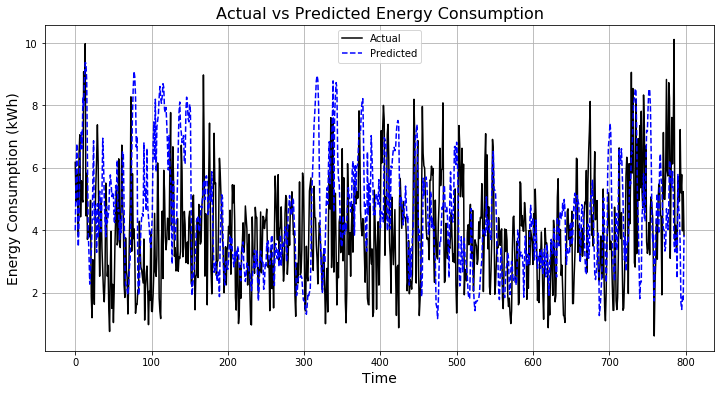

In [88]:
import matplotlib.pyplot as plt

# Evaluate the model
def evaluate_model(model, data, seq_length=30):
    model.eval()
    inputs = torch.tensor(data[:seq_length, :-1], dtype=torch.float32).to(DEVICE)
    actuals = []
    predictions = []
    
    # Loop through data to make predictions
    for i in range(seq_length, len(data)):
        x = torch.tensor(data[i-seq_length:i, :-1], dtype=torch.float32).to(DEVICE)
        y_true = data[i, -1]
        actuals.append(y_true)
        
        # Ensure input x has 3 dimensions: (batch_size, seq_length, input_size)
        x = x.unsqueeze(0)  # Add batch dimension (1, seq_length, input_size)
        
        with torch.no_grad():
            y_pred = model(x).cpu().numpy()[0]  # Get the prediction for the current input
            predictions.append(y_pred)
    
    return actuals, predictions

# Evaluate the model on the entire dataset
data = combined_data_mac[["consumption_kwh", "temperature", "humidity", "wind_speed"]].values
actuals, predictions = evaluate_model(model, data)

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(actuals, label="Actual", color="black")
plt.plot(predictions, label="Predicted", color="blue", linestyle="--")
plt.xlabel("Time", fontsize=14)
plt.ylabel("Energy Consumption (kWh)", fontsize=14)
plt.title("Actual vs Predicted Energy Consumption", fontsize=16)
plt.legend()
plt.grid(True)
plt.show()


Eval — MSE: 0.001835 | RMSE: 0.042835 | MAE: 0.026102 | Bias: 0.000960


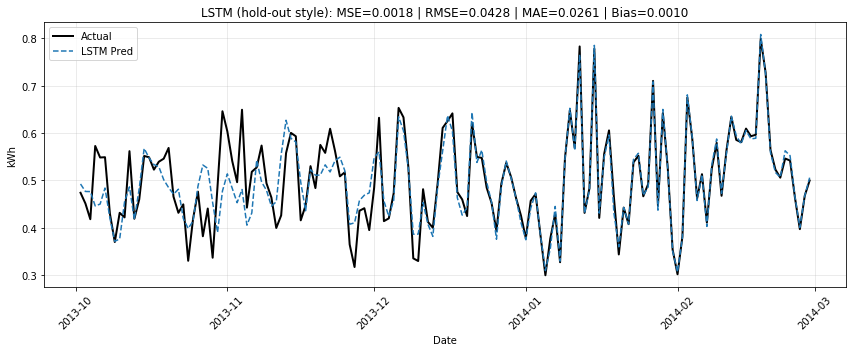

In [89]:
# === EVALUATE + PLOT (tự inverse qua mean/std của consumption_kwh, không cần data_scaler) ===
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt

# an toàn: nếu SEQ_LEN chưa có, set theo lúc train (thường 10)
try:
    SEQ_LEN
except NameError:
    SEQ_LEN = 10

model.eval()
with torch.no_grad():
    preds_scaled, targs_scaled, ts_list = [], [], []

    # timestamp sạch (tránh duplicated col)
    mac_clean = combined_data_mac.loc[:, ~combined_data_mac.columns.duplicated()].dropna().reset_index(drop=True)
    ts_all = mac_clean["timestamp"].values  # full timestamps

    for i in range(len(dataset)):
        x_i, y_i = dataset[i]
        # Bỏ STRIDE, index “i + SEQ_LEN” mapping thẳng theo dataset
        t_idx = i + SEQ_LEN
        if t_idx >= len(ts_all):
            continue

        x_i = x_i.unsqueeze(0).to(DEVICE)  # (1, T, 4) — vì input_size=4
        p_i = model(x_i).squeeze().detach().cpu().item()

        preds_scaled.append(p_i)       # đang ở scale của data dùng lúc train (giả định standardize)
        targs_scaled.append(float(y_i))
        ts_list.append(ts_all[t_idx])

# --- Tự inverse cho cột consumption_kwh bằng mean/std từ dữ liệu gốc ---
cons_mean  = combined_data_mac["consumption_kwh"].mean()
cons_scale = combined_data_mac["consumption_kwh"].std(ddof=0)  # ddof=0 nhất quán với StandardScaler

# Nếu anh train KHÔNG scale target, thì comment 2 dòng dưới & dùng preds = np.array(preds_scaled) luôn
preds = np.array(preds_scaled) * cons_scale + cons_mean
targs = np.array(targs_scaled) * cons_scale + cons_mean

# --- Metrics ---
mse  = np.mean((preds - targs)**2)
rmse = sqrt(mse)
mae  = np.mean(np.abs(preds - targs))
bias = float(np.mean(preds - targs))
print(f"Eval — MSE: {mse:.6f} | RMSE: {rmse:.6f} | MAE: {mae:.6f} | Bias: {bias:.6f}")

# --- Plot 150 điểm cuối cho nét ---
take_last = min(150, len(ts_list))
plt.figure(figsize=(12,5))
plt.plot(ts_list[-take_last:], targs[-take_last:], label="Actual", linewidth=2, color="black")
plt.plot(ts_list[-take_last:], preds[-take_last:], label="LSTM Pred", linestyle="--")
plt.title(f"LSTM (hold-out style): MSE={mse:.4f} | RMSE={rmse:.4f} | MAE={mae:.4f} | Bias={bias:.4f}")
plt.xlabel("Date"); plt.ylabel("kWh")
plt.xticks(rotation=45); plt.grid(True, alpha=0.3); plt.legend()
plt.tight_layout()
plt.show()

Forecast next 7 days (kWh): [5.9851 4.8601 4.2661 3.5214 3.7623 3.7203 4.3212]
Forecast next 30 days (kWh) — first 10: [5.9851 4.8601 4.2661 3.5214 3.7623 3.7203 4.3212 5.0431 5.3173 5.1345] ...


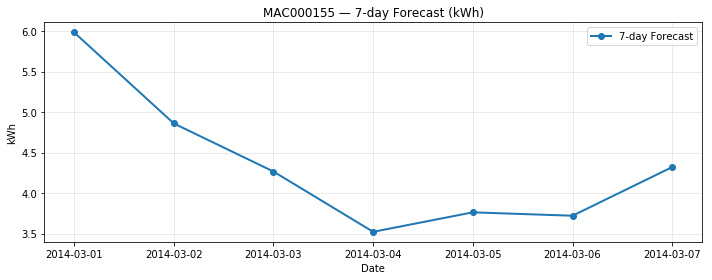

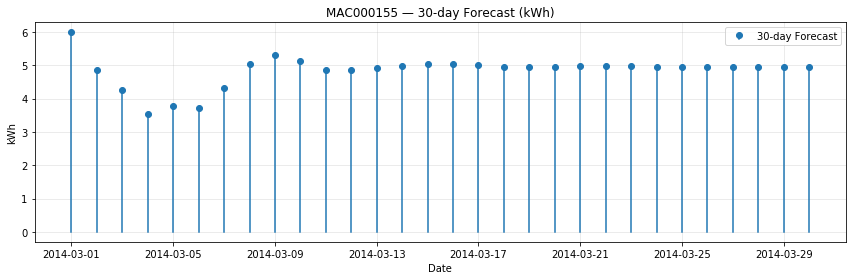

In [90]:
# ===== FULL FORECAST (input_size=4) + PLOT FIX =====
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

# ==== 1) Tham số khớp lúc train ====
try:
    SEQ_LEN
except NameError:
    SEQ_LEN = 10  # đổi nếu lúc train anh dùng seq_len khác

# ==== 2) Build mảng 4 features theo đúng thứ tự ====
# Cần sẵn: combined_data_mac (đã merge thời tiết), model (đã train), DEVICE
df_mac = combined_data_mac.loc[:, ~combined_data_mac.columns.duplicated()].copy()

required_cols = ["consumption_kwh", "temperature", "humidity", "wind_speed"]
missing = [c for c in required_cols if c not in df_mac.columns]
if missing:
    raise KeyError(f"Thiếu cột: {missing}")

mac_df_eval = df_mac[required_cols + ["timestamp"]].dropna().reset_index(drop=True)
arr = mac_df_eval[required_cols].values.astype(np.float32)  # (N,4)
ts_all = pd.to_datetime(mac_df_eval["timestamp"].values)

if len(arr) <= SEQ_LEN:
    raise ValueError(f"Chuỗi quá ngắn (len={len(arr)}) so với SEQ_LEN={SEQ_LEN}")

# ==== 3) Forecast cho model input_size=4 ====
def recursive_forecast_4f(model, last_window, steps, future_weather=None, device="cpu"):
    """
    last_window: np.array (SEQ_LEN, 4) = [cons, temp, humid, wind]
    future_weather: None hoặc (steps,3) = [temp, humid, wind] cho từng ngày.
                    None => giữ nguyên weather cuối (hold-last).
    """
    model.eval()
    win = last_window.copy().astype(np.float32)    # (T,4)
    fcst = []

    if future_weather is None:
        hold_feat = win[-1, 1:].copy()            # (3,) = [temp, humid, wind]

    with torch.no_grad():
        for t in range(steps):
            x = torch.from_numpy(win).unsqueeze(0).to(device)   # (1,T,4)
            yhat = model(x).squeeze().detach().cpu().item()     # scalar
            fcst.append(yhat)

            # chọn weather hôm t
            if future_weather is None:
                next_weather = hold_feat
            else:
                next_weather = future_weather[t]

            next_row = np.array([yhat, next_weather[0], next_weather[1], next_weather[2]], dtype=np.float32)
            win = np.vstack([win[1:], next_row])

    return np.array(fcst, dtype=np.float32)

# ==== 4) Chuẩn bị cửa sổ & (tùy chọn) thời tiết tương lai ====
last_window = arr[-SEQ_LEN:, :]   # (SEQ_LEN,4)
future_weather_7  = None          # giữ nguyên weather cuối
future_weather_30 = None          # giữ nguyên weather cuối

# ==== 5) Forecast 7 & 30 ngày ====
fcst_7  = recursive_forecast_4f(model, last_window, steps=7,  future_weather=future_weather_7,  device=DEVICE)
fcst_30 = recursive_forecast_4f(model, last_window, steps=30, future_weather=future_weather_30, device=DEVICE)

print("Forecast next 7 days (kWh):", np.round(fcst_7, 4))
print("Forecast next 30 days (kWh) — first 10:", np.round(fcst_30[:10], 4), "...")

# ==== 6) Tạo timestamp tương lai ====
last_ts = pd.to_datetime(mac_df_eval["timestamp"].max())
future_7  = pd.date_range(last_ts + pd.Timedelta(days=1), periods=7,  freq="D")
future_30 = pd.date_range(last_ts + pd.Timedelta(days=1), periods=30, freq="D")

# ==== 7) Plot 7 ngày (line) ====
plt.figure(figsize=(10,4))
plt.plot(future_7, fcst_7, marker="o", linewidth=2, label="7-day Forecast")
plt.title("MAC000155 — 7-day Forecast (kWh)")
plt.xlabel("Date"); plt.ylabel("kWh")
plt.grid(True, alpha=0.3); plt.legend()
plt.tight_layout(); plt.show()

# ==== 8) Plot 30 ngày (STEM — bản tương thích, bỏ use_line_collection) ====
plt.figure(figsize=(12,4))
markerline, stemlines, baseline = plt.stem(future_30, fcst_30)  # KHÔNG dùng use_line_collection
plt.setp(stemlines, linewidth=1.5)
plt.setp(markerline, markersize=6)
plt.setp(baseline, visible=False)  # gọn hơn
plt.title("MAC000155 — 30-day Forecast (kWh)")
plt.xlabel("Date"); plt.ylabel("kWh")
plt.grid(True, alpha=0.3)
plt.legend(["30-day Forecast"])
plt.tight_layout(); plt.show()


